# 1. Introduction

#### Dataset
- This dataset is obtained from Kaggle: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

#### Context
- Cardiovascular disease (CVDs) is the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of five CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs.
- People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management.  
- This dataset contains 11 features that can be used to predict possible heart disease.
- Let's train a machine learning model to assist with diagnosing this disease.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Let's import the libraries we will use.

## 1.Data Gattering and Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

RANDOM_STATE = 55

In [2]:
!gdown --id 1k9P5MdMxdi5LufOBoLI-x6mFrv_o4zQx

df = pd.read_csv('heart.csv')
df.head()

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1k9P5MdMxdi5LufOBoLI-x6mFrv_o4zQx
To: /content/heart.csv
100% 35.9k/35.9k [00:00<00:00, 48.8MB/s]


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## 2.Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
cat_cols = [var for var in df.columns if df[var].dtypes == 'object']

print(f'Categorical columns: {cat_cols}')

Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


### Spliting Data

Let's choose the variables that will be the input features of the model.
- The target is `HeartDisease`.
- All other variables are features that can potentially be used to predict the target, `HeartDisease`.

In [6]:
features = [x for x in df.columns if x != 'HeartDisease']
X = df[features]
y = df['HeartDisease']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [8]:
print(f'train sample: {len(X_train)}')
print(f'validation sample: {len(X_val)}')
print(f'Proportion target: {sum(y_train)/len(y_train)}')

train sample: 734
validation sample: 184
Proportion target: 0.5517711171662125


### Outlier

In [9]:
num_cols = [var for var in X_train.columns if df[var].dtypes != 'object']
X_removed = num_cols.remove('FastingBS')
print(f'Numerical columns: {num_cols}')

Numerical columns: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


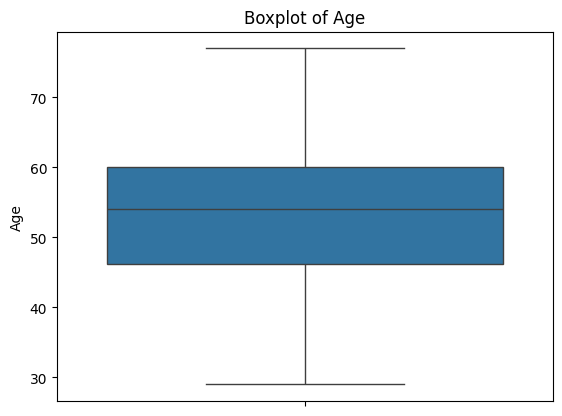

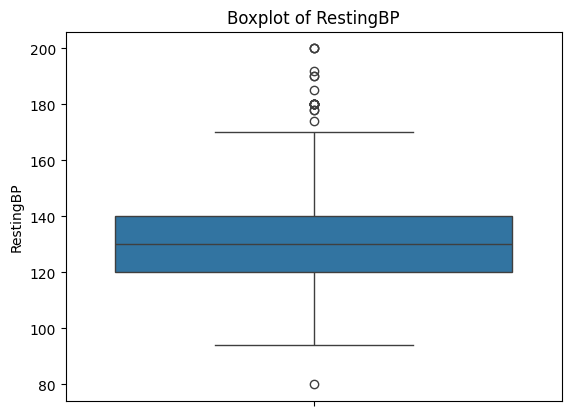

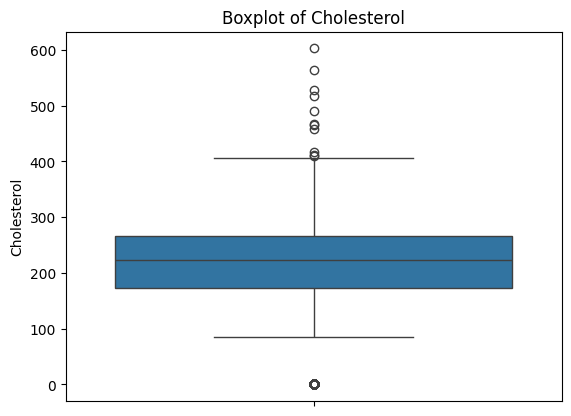

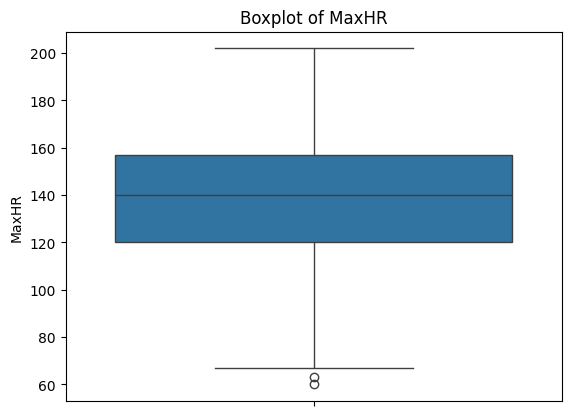

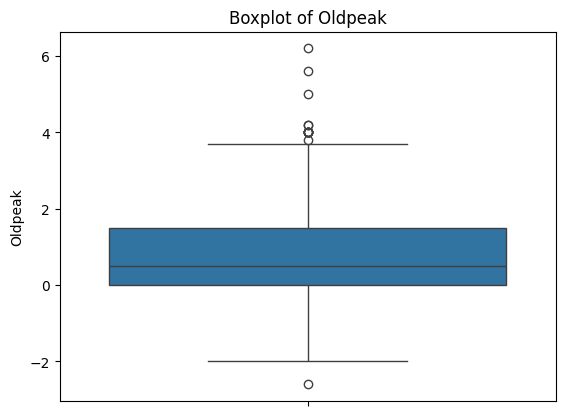

In [10]:
#check outlie
for col in num_cols:
  sns.boxplot(X_train[col])
  plt.title(f'Boxplot of {col}')
  plt.show()

In [11]:
features = num_cols.copy()

for feature in features:
    Q1 = X_train[feature].quantile(0.25)
    Q3 = X_train[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap pada training data
    X_train[feature] = np.where(X_train[feature] < lower_bound, lower_bound, X_train[feature])
    X_train[feature] = np.where(X_train[feature] > upper_bound, upper_bound, X_train[feature])

    # Cap pada validation/test data (gunakan Q1, Q3 dari training)
    X_val[feature] = np.where(X_val[feature] < lower_bound, lower_bound, X_val[feature])
    X_val[feature] = np.where(X_val[feature] > upper_bound, upper_bound, X_val[feature])


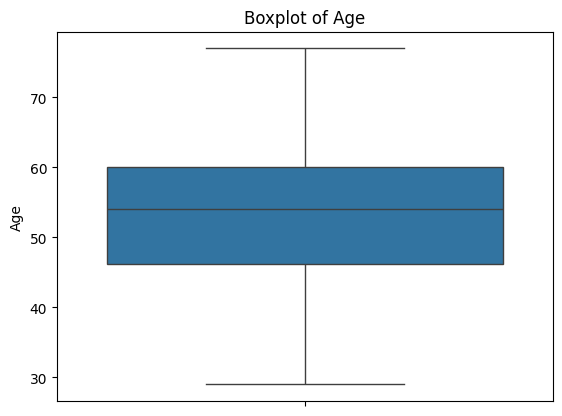

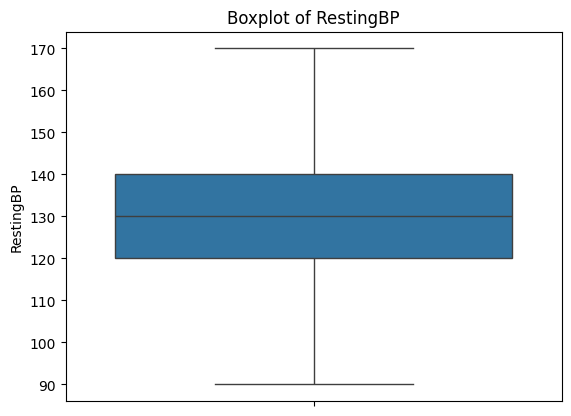

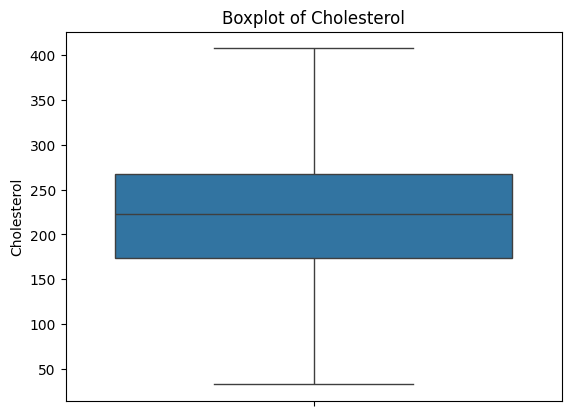

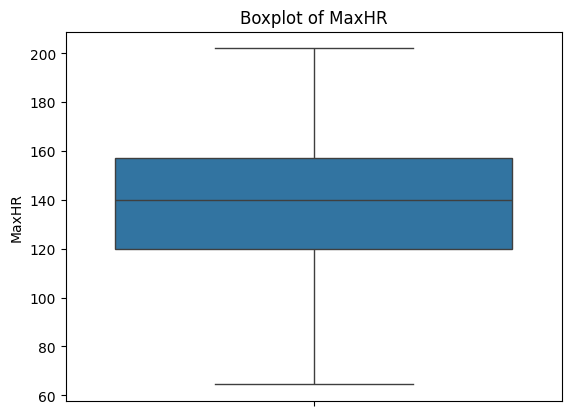

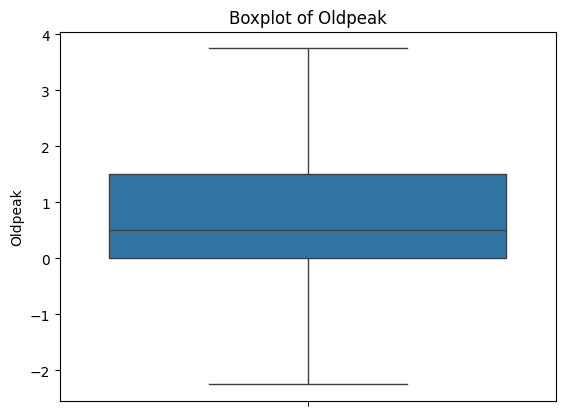

In [12]:
#check outlie
for col in num_cols:
  sns.boxplot(X_train[col])
  plt.title(f'Boxplot of {col}')
  plt.show()

In [13]:
X_train_final = pd.concat([X_train, X_removed], axis=1)
X_train_final.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
309,57.0,M,ASY,95.0,32.625,1,Normal,182.0,N,0.7,Down
30,53.0,M,NAP,145.0,407.625,0,Normal,130.0,N,0.0,Flat
869,59.0,M,NAP,150.0,212.000,1,Normal,157.0,N,1.6,Up
159,54.0,M,ATA,160.0,195.000,0,ST,130.0,N,1.0,Up
307,53.0,M,ATA,130.0,32.625,0,ST,120.0,N,0.7,Down


### Encoding

Pandas has a built-in method to one-hot encode variables, it is the function `pd.get_dummies`. There are several arguments to this function, but here we will use only a few. They are:

 - data: DataFrame to be used
 - prefix: A list with prefixes, so we know which value we are dealing with
 - columns: the list of columns that will be one-hot encoded. 'prefix' and 'columns' must have the same length.

In [14]:
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
X_train_final = pd.get_dummies(data=X_train_final, prefix=cat_cols, columns=cat_cols)
X_val = pd.get_dummies(data=X_val, prefix=cat_cols, columns=cat_cols)

#replace from bool to numerik
X_train_final = X_train_final.replace({True: 1, False:0})
X_val = X_val.replace({True: 1, False:0})

print(X_train_final)

      Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  Sex_F  Sex_M  \
309  57.0       95.0       32.625          1  182.0      0.7      0      1   
30   53.0      145.0      407.625          0  130.0      0.0      0      1   
869  59.0      150.0      212.000          1  157.0      1.6      0      1   
159  54.0      160.0      195.000          0  130.0      1.0      0      1   
307  53.0      130.0       32.625          0  120.0      0.7      0      1   
..    ...        ...          ...        ...    ...      ...    ...    ...   
541  76.0      104.0      113.000          0  120.0      3.5      0      1   
893  57.0      154.0      232.000          0  164.0      0.0      0      1   
295  61.0      105.0       32.625          1  110.0      1.5      0      1   
666  52.0      128.0      205.000          1  184.0      0.0      0      1   
461  63.0      136.0       32.625          0   84.0      0.0      0      1   

     ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \

<ipython-input-14-a2204548fd50>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_final = X_train_final.replace({True: 1, False:0})
<ipython-input-14-a2204548fd50>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_val = X_val.replace({True: 1, False:0})


## 3.Auto EDA

In [15]:
!pip install ydata_profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=4519132ca74bf001a30a1e0c4df82d23ecfd08428479d8402b6725165258b791
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [16]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title ='heart_report', explorative=True)
profile.to_file('heart_repot.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<00:00, 23.68it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 4.Feature Engineering

### Standardization

In [17]:
#Scalingg
columns_to_scale = X_train_final.select_dtypes('int64','float64').columns

scaler = MinMaxScaler()
X_train_scaled = X_train_final.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_final[columns_to_scale])
X_val_scaled = X_val.copy()
X_val_scaled[columns_to_scale] = scaler.transform(X_val[columns_to_scale])

X_train_scale_df = pd.DataFrame(X_train_scaled, columns=X_train_final.columns)
X_val_scale_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)

print(X_train_scale_df.head())

      Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  Sex_F  Sex_M  \
309  57.0       95.0       32.625        1.0  182.0      0.7    0.0    1.0   
30   53.0      145.0      407.625        0.0  130.0      0.0    0.0    1.0   
869  59.0      150.0      212.000        1.0  157.0      1.6    0.0    1.0   
159  54.0      160.0      195.000        0.0  130.0      1.0    0.0    1.0   
307  53.0      130.0       32.625        0.0  120.0      0.7    0.0    1.0   

     ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
309                1.0                0.0                0.0   
30                 0.0                0.0                1.0   
869                0.0                0.0                1.0   
159                0.0                1.0                0.0   
307                0.0                1.0                0.0   

     ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
309               0.0             0.0                1.0            0.0

### multikolenearization

In [18]:
X = X_train_scale_df.select_dtypes(include='number')

# Adding a constant column for intercept
X['intercept'] = 1

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF, excluding the intercept
vif_data = vif_data[vif_data['Feature'] != 'intecept']
vif_data

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Feature,VIF
0,Age,1.427682
1,RestingBP,1.146293
2,Cholesterol,1.244456
3,FastingBS,1.140447
4,MaxHR,1.572311
5,Oldpeak,1.513735
6,Sex_F,inf
7,Sex_M,inf
8,ChestPainType_ASY,inf
9,ChestPainType_ATA,inf


## 5.Modeling


🔍 Training Decision Tree...
📈 CV Accuracy: 0.7740 ± 0.0420


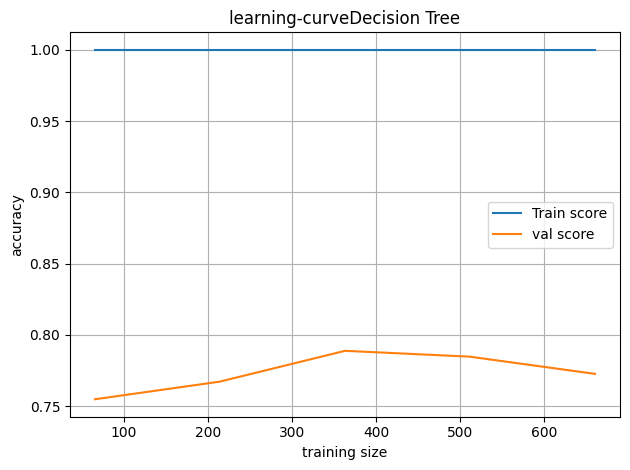


🔍 Training Random Forest...
📈 CV Accuracy: 0.8664 ± 0.0352


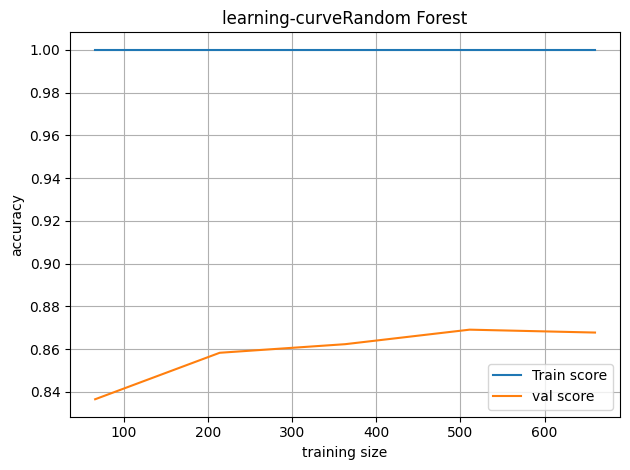


🔍 Training XGBoost...
📈 CV Accuracy: 0.8597 ± 0.0376


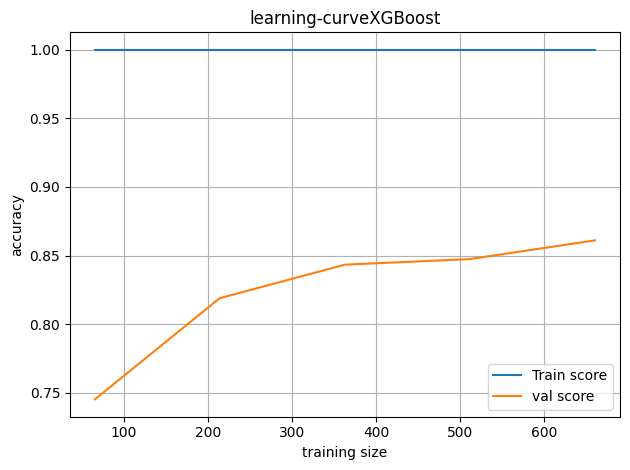

In [19]:
#model dictionary
models = {
    'Decision Tree' : DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest' : RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1),
    'XGBoost' : XGBClassifier( eval_metric='logloss', random_state=RANDOM_STATE)
}

#Loop Model
for name, model in models.items():
   print(f"\n🔍 Training {name}...")

   #Cross validation
   scores = cross_val_score(model, X_train_scale_df, y_train, cv=10, scoring='accuracy')
   print(f"📈 CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

   #learning curve
   train_sizes, train_scores, val_scores = learning_curve(model, X_train_scale_df, y_train, cv=10, scoring='accuracy', n_jobs=-1)

   train_mean = np.mean(train_scores, axis=1)
   val_mean = np.mean(val_scores, axis=1)

   #plot
   plt.figure()
   plt.plot(train_sizes, train_mean, label='Train score')
   plt.plot(train_sizes, val_mean, label='val score')

   plt.title(f'learning-curve{name}')
   plt.xlabel('training size')
   plt.ylabel('accuracy')
   plt.legend()
   plt.grid(True)
   plt.tight_layout()
   plt.show()

In [20]:
!pip install optuna xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.0 MB/s eta 0:00:00


### Hyperparameter Tuning

[I 2025-04-09 13:03:22,359] A new study created in memory with name: no-name-f3da6376-65c8-4b96-bfac-e1bcbdd8beb4
[I 2025-04-09 13:03:25,386] Trial 0 finished with value: 0.8609542447115832 and parameters: {'n_estimators': 241, 'max_depth': 28, 'min_samples_split': 9}. Best is trial 0 with value: 0.8609542447115832.
[I 2025-04-09 13:03:28,852] Trial 1 finished with value: 0.8609542447115833 and parameters: {'n_estimators': 226, 'max_depth': 21, 'min_samples_split': 3}. Best is trial 1 with value: 0.8609542447115833.
[I 2025-04-09 13:03:30,917] Trial 2 finished with value: 0.8623241077252818 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 2}. Best is trial 2 with value: 0.8623241077252818.
[I 2025-04-09 13:03:33,149] Trial 3 finished with value: 0.8582424750722206 and parameters: {'n_estimators': 170, 'max_depth': 25, 'min_samples_split': 3}. Best is trial 2 with value: 0.8623241077252818.
[I 2025-04-09 13:03:34,903] Trial 4 finished with value: 0.866405740378

Best Params - Random Forest: {'n_estimators': 299, 'max_depth': 5, 'min_samples_split': 2}


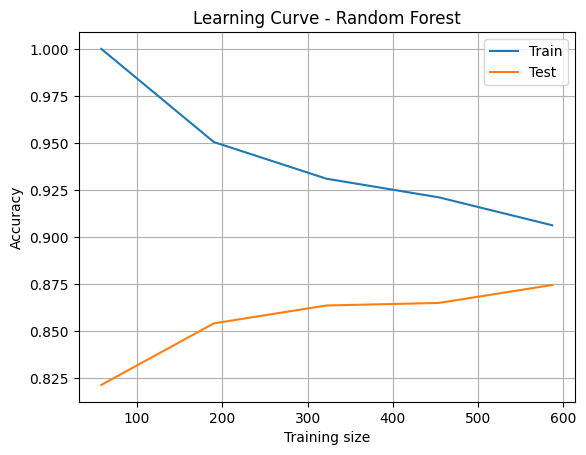

In [21]:
import optuna

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
    }

    model = RandomForestClassifier(**params, random_state=RANDOM_STATE, n_jobs=-1)
    score = cross_val_score(model, X_train_scale_df, y_train, cv=5, scoring='accuracy').mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)

print("Best Params - Random Forest:", study_rf.best_params)

# Learning curve
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=RANDOM_STATE)
train_sizes, train_scores, test_scores = learning_curve(best_rf, X_train_scale_df, y_train, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.title('Learning Curve - Random Forest')
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Evaluation

### Predict Probabilitas

In [23]:
#train best model
best_rf.fit(X_train_scale_df, y_train)
#prediction
y_pred_prob = best_rf.predict_proba(X_val_scale_df)[:, 1]
y_pred = best_rf.predict(X_val_scale_df)

### Classification report

In [24]:
print('Classification Report: \n')
print(classification_report(y_val,y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        81
           1       0.89      0.89      0.89       103

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



### Confusion matrix

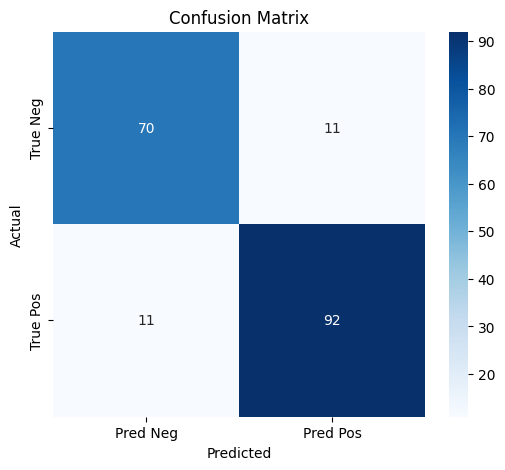

In [25]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ROC

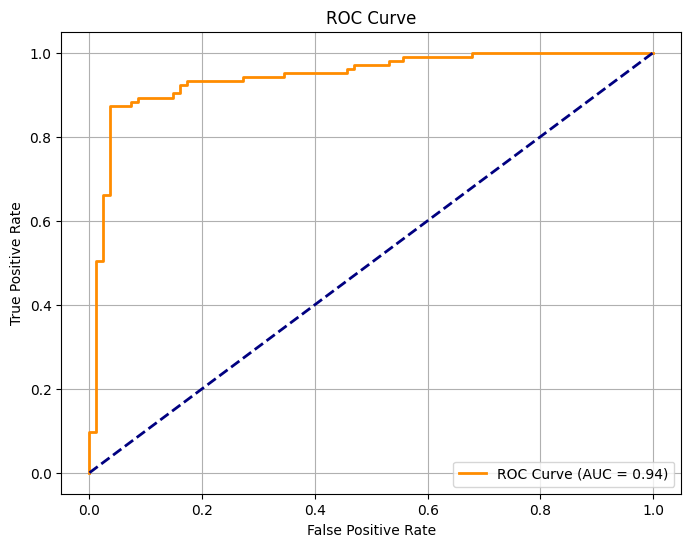

In [28]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()